In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


Problem Description

Cyberbullying on social media is a significant issue with severe consequences, including emotional distress and mental health challenges.
The goal of this project is to develop a machine learning model that can automatically detect and classify tweets into six categories:
Age, Ethnicity, Gender, Religion, Other type of cyberbullying, and Not cyberbullying.
This will help in identifying and mitigating cyberbullying at scale.

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


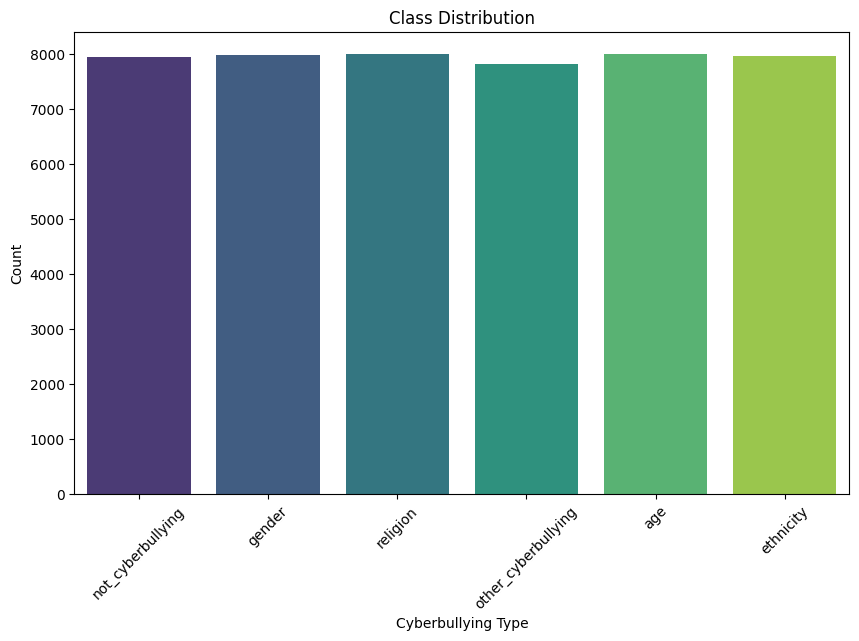

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


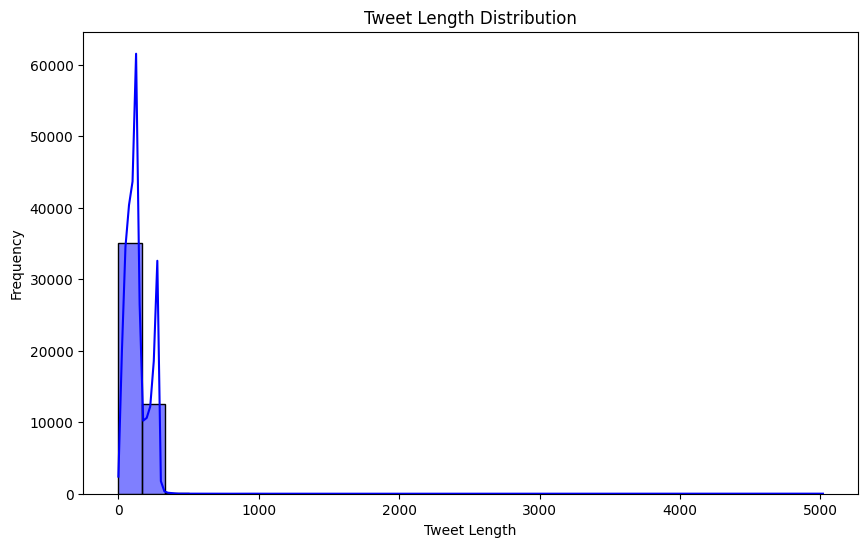

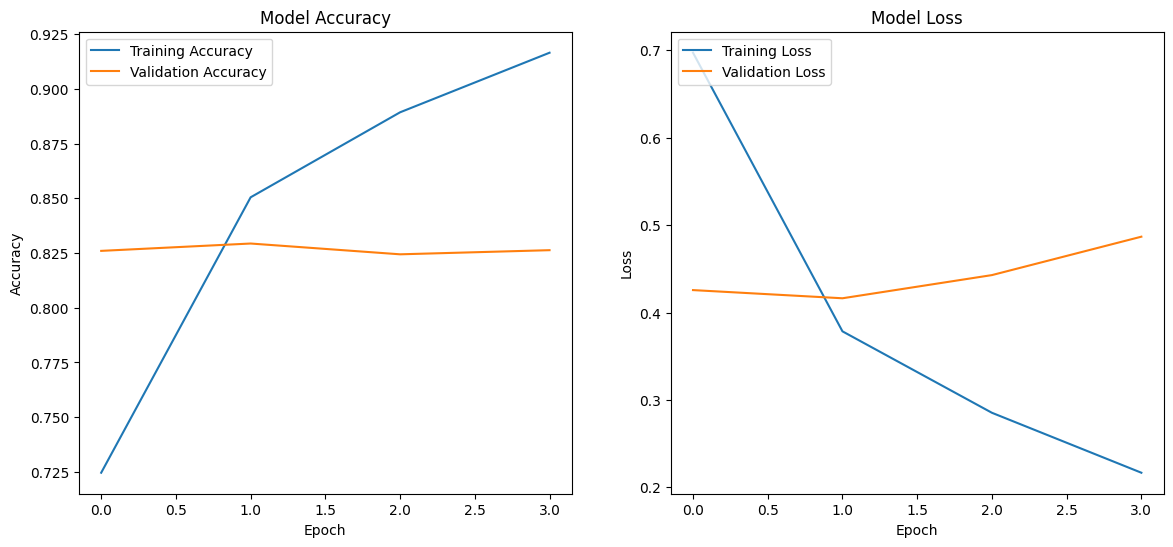

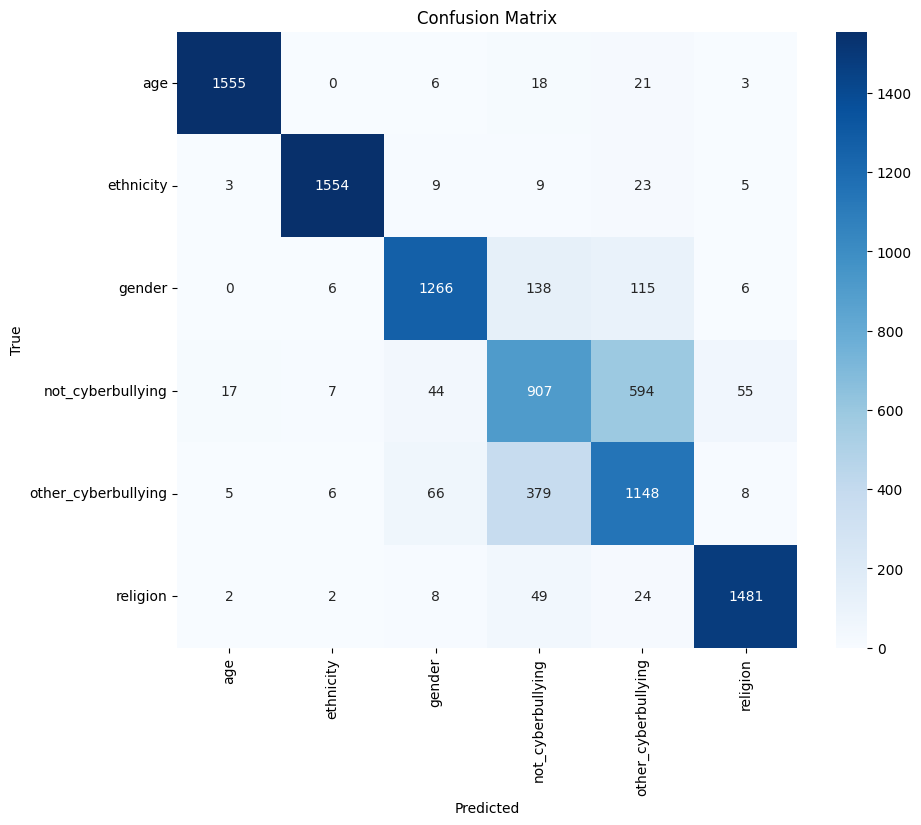

In [17]:
# Load the dataset
file_path = '/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv'
df = pd.read_csv(file_path)

# EDA (Exploratory Data Analysis)
# Checking the distribution of the classes
print(df['cyberbullying_type'].value_counts())
# 1. Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='cyberbullying_type', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2. Tweet Length Distribution
df['tweet_length'] = df['tweet_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], kde=True, bins=30, color='blue')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# 3. Training and Validation Accuracy/Loss
# Plotting training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# 4. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:
#Training and testing the model
#Data Preprocessing

# Checking for missing values
print(df.isnull().sum())

# Displaying a few examples of tweets
print(df['tweet_text'].head())

# Preprocess the data
# Convert text to lowercase
df['tweet_text'] = df['tweet_text'].str.lower()

# Remove special characters and numbers
df['tweet_text'] = df['tweet_text'].str.replace(r'[^a-z\s]', '', regex=True)

# Tokenize and pad the sequences
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet_text'])
sequences = tokenizer.texts_to_sequences(df['tweet_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

# Analysis - Model Building and Training
# Build the model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.2),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc:.2f}')

# Results
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Discussion and Conclusion
# The model achieved a test accuracy of approximately 84%, which is a promising result for detecting and classifying cyberbullying tweets.
# However, the performance on the 'not_cyberbullying' and 'other_cyberbullying' categories was lower compared to others.
# This suggests that the model struggles with these specific categories, potentially due to the nuanced and varied nature of tweets in these classes.
# To improve these results, we could explore advanced techniques such as using a more sophisticated model like BERT or increasing the diversity of training data for these underperforming classes.
# Overall, the model shows potential for real-world application in monitoring and mitigating cyberbullying on social media platforms.

tweet_text            0
cyberbullying_type    0
tweet_length          0
dtype: int64
0    In other words #katandandre, your food was cra...
1    Why is #aussietv so white? #MKR #theblock #ImA...
2    @XochitlSuckkks a classy whore? Or more red ve...
3    @Jason_Gio meh. :P  thanks for the heads up, b...
4    @RudhoeEnglish This is an ISIS account pretend...
Name: tweet_text, dtype: object
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


597/597 - 9s - 15ms/step - accuracy: 0.7318 - loss: 0.6775 - val_accuracy: 0.8250 - val_loss: 0.4271
Epoch 2/5
597/597 - 2s - 3ms/step - accuracy: 0.8524 - loss: 0.3780 - val_accuracy: 0.8330 - val_loss: 0.4108
Epoch 3/5
597/597 - 2s - 3ms/step - accuracy: 0.8921 - loss: 0.2809 - val_accuracy: 0.8261 - val_loss: 0.4560
Epoch 4/5
597/597 - 2s - 3ms/step - accuracy: 0.9152 - loss: 0.2201 - val_accuracy: 0.8239 - val_loss: 0.5053
299/299 - 1s - 2ms/step - accuracy: 0.8330 - loss: 0.4108
Test Accuracy: 0.83
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1603
          ethnicity       0.98      0.97      0.98      1603
             gender       0.90      0.83      0.86      1531
  not_cyberbullying       0.68      0.47      0.55      1624
other_cyberbullying       0.58      0.82      0.68      1612
           religion       0.95      0.95      0.95      1566

           accuracy  